<a href="https://colab.research.google.com/github/cinnaavox/favorita_sales_forecasting/blob/main/Corporaci%C3%B3n_Favorita_Grocery_Sales_Forecasting_Week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Block 0 — Setup & Helfer

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
!pip install -q gdown pyarrow fastparquet

import os, io, gc, requests, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

def load_csv_from_url(url):
    r = requests.get(url); r.raise_for_status()
    return pd.read_csv(io.StringIO(r.text))

def mem(tag=""):
    rss = psutil.Process(os.getpid()).memory_info().rss/1e9
    print(f"[RAM]{' '+tag if tag else ''}: {rss:.2f} GB")

def optimize_df(df):
    if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])
    for c in ('store_nbr','item_nbr','year','month','day','day_of_week'):
        if c in df.columns: df[c] = pd.to_numeric(df[c], downcast='integer')
    if 'unit_sales' in df.columns: df['unit_sales'] = pd.to_numeric(df['unit_sales'], downcast='float')
    if 'onpromotion' in df.columns: df['onpromotion'] = df['onpromotion'].fillna(False).astype('bool')
    return df

SAVE_DIR = "/content/time_series_course"
PARTS_DIR = f"{SAVE_DIR}/train_pich_full"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(PARTS_DIR, exist_ok=True)

## Block 1 — IDs & kleine Dateien laden (ohne df_train hier!)

In [10]:
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))

# Grundpflege kleine Frames
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate('linear')
df_stores = optimize_df(df_stores)
df_items  = optimize_df(df_items)
df_transactions = optimize_df(df_transactions)
mem("small files loaded")

[RAM] small files loaded: 0.32 GB


## Block 2 — train.csv laden (gdown)

In [11]:
import gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=c89e5e1c-034e-4a84-81c5-869c2462f30c
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:26<00:00, 192MB/s]


'train.csv'

## Block 3 — Pichincha-Stores bestimmen

In [12]:
store_ids = df_stores.loc[df_stores['state'] == 'Pichincha', 'store_nbr'].unique()
print("Anzahl Pichincha-Stores:", len(store_ids))

Anzahl Pichincha-Stores: 19


## Block 4 — Voller Pichincha-Datensatz als Parquet-Dataset (verlustfrei, RAM-schonend)

In [13]:
import pyarrow as pa, pyarrow.parquet as pq

for root, dirs, files in os.walk(PARTS_DIR):
    for f in files:
        os.remove(os.path.join(root, f))

usecols = ['date','store_nbr','item_nbr','unit_sales','onpromotion']

for i, chunk in enumerate(pd.read_csv("train.csv", usecols=usecols, chunksize=10**6)):
    # Filter auf Pichincha
    chunk = chunk[chunk['store_nbr'].isin(store_ids)].copy()
    # Clean
    chunk['date'] = pd.to_datetime(chunk['date'])
    chunk['unit_sales'] = pd.to_numeric(chunk['unit_sales'], errors='coerce').fillna(0).clip(lower=0)
    chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('bool')
    chunk['year'] = chunk['date'].dt.year.astype('int16')
    chunk = optimize_df(chunk)
    # Partitioniert nach year, store_nbr schreiben
    table = pa.Table.from_pandas(chunk, preserve_index=False)
    pq.write_to_dataset(table, root_path=PARTS_DIR, partition_cols=['year','store_nbr'])
    del chunk, table
    if (i+1) % 3 == 0:
        gc.collect(); mem(f"written chunks: {i+1}")
mem("all chunks written")

[RAM] written chunks: 3: 0.45 GB
[RAM] written chunks: 6: 0.44 GB
[RAM] written chunks: 9: 0.45 GB
[RAM] written chunks: 12: 0.40 GB
[RAM] written chunks: 15: 0.48 GB
[RAM] written chunks: 18: 0.41 GB
[RAM] written chunks: 21: 0.45 GB
[RAM] written chunks: 24: 0.42 GB
[RAM] written chunks: 27: 0.42 GB
[RAM] written chunks: 30: 0.42 GB
[RAM] written chunks: 33: 0.42 GB
[RAM] written chunks: 36: 0.42 GB
[RAM] written chunks: 39: 0.43 GB
[RAM] written chunks: 42: 0.43 GB
[RAM] written chunks: 45: 0.42 GB
[RAM] written chunks: 48: 0.42 GB
[RAM] written chunks: 51: 0.41 GB
[RAM] written chunks: 54: 0.43 GB
[RAM] written chunks: 57: 0.42 GB
[RAM] written chunks: 60: 0.43 GB
[RAM] written chunks: 63: 0.43 GB
[RAM] written chunks: 66: 0.42 GB
[RAM] written chunks: 69: 0.42 GB
[RAM] written chunks: 72: 0.42 GB
[RAM] written chunks: 75: 0.43 GB
[RAM] written chunks: 78: 0.40 GB
[RAM] written chunks: 81: 0.44 GB
[RAM] written chunks: 84: 0.42 GB
[RAM] written chunks: 87: 0.42 GB
[RAM] written chu

## Block 5 — Arbeits-df_train (≈2 Mio, jahr-stratifiziert) für EDA/Features/Modelle

In [35]:
from pathlib import Path
import pandas as pd
import numpy as np
import gc

TARGET_TOTAL = 2_000_000
ROOT = Path(PARTS_DIR)


year_dirs = [d for d in ROOT.glob("year=*") if d.is_dir() and "=" in d.name]
if not year_dirs:
    raise RuntimeError(
        f"Keine year=*-Partitionen unter {PARTS_DIR} gefunden.\n"
        "Bitte zuerst Block 4 ausführen, damit das Parquet-Dataset geschrieben wird."
    )

years = sorted(int(d.name.split("=", 1)[1]) for d in year_dirs)
print("Gefundene Jahre:", years)


per_year = {y: TARGET_TOTAL // len(years) for y in years}
per_year[years[-1]] += TARGET_TOTAL - sum(per_year.values())

dfs = []

for y in years:
    cap = per_year[y]
    files_y = list((ROOT / f"year={y}").rglob("*.parquet"))
    if not files_y:
        print(f"Warnung: Keine Dateien für Jahr {y} gefunden, überspringe…")
        continue

    pool = []
    pooled_rows = 0

    for fp in files_y:

        part = pd.read_parquet(fp, columns=['date','item_nbr','unit_sales','onpromotion'])


        store_val = None
        for seg in fp.parts:
            if isinstance(seg, str) and seg.startswith("store_nbr="):
                store_val = int(seg.split("=", 1)[1])
                break
        if store_val is None:

            for seg in map(str, fp.parts):
                if seg.startswith("store_nbr="):
                    store_val = int(seg.split("=", 1)[1])
                    break
        if store_val is None:
            raise ValueError(f"Konnte store_nbr nicht aus Pfad lesen: {fp}")

        part['store_nbr'] = store_val


        pool.append(part)
        pooled_rows += len(part)
        del part


        if pooled_rows >= cap * 2:
            tmp = pd.concat(pool, ignore_index=True)
            take_mid = min(len(tmp), cap * 2)
            tmp = tmp.sample(take_mid, random_state=42)
            pool = [tmp]
            pooled_rows = len(tmp)
            del tmp
        gc.collect()


    if pool:
        df_y = pd.concat(pool, ignore_index=True)
        df_y['date'] = pd.to_datetime(df_y['date'])
        df_y['store_nbr'] = pd.to_numeric(df_y['store_nbr'], downcast='integer')
        df_y['item_nbr']  = pd.to_numeric(df_y['item_nbr'],  downcast='integer')
        df_y['unit_sales'] = pd.to_numeric(df_y['unit_sales'], downcast='float')
        df_y['onpromotion'] = df_y['onpromotion'].fillna(False).astype(bool)

        take = min(len(df_y), cap)
        df_y = df_y.sample(take, random_state=42).reset_index(drop=True)
        dfs.append(df_y)
        del df_y, pool
        gc.collect()
    else:
        print(f"Warnung: Jahr {y} hatte leeren Pool.")

if not dfs:
    raise RuntimeError("Kein Sample erstellt. Prüfe Block 4 (Dataset schreiben).")

df_train = pd.concat(dfs, ignore_index=True)
print("df_train shape:", df_train.shape)
print("Zeitspanne:", df_train['date'].min().date(), "→", df_train['date'].max().date())

Gefundene Jahre: [2013, 2014, 2015, 2016, 2017]
df_train shape: (2000000, 5)
Zeitspanne: 2013-01-02 → 2017-08-15


## Block 6 — EDA Step 1: Missing Data (kompakt)

In [18]:
print("Missing in df_train:")
print(df_train.isnull().sum(), "\n")

print("Missing in other tables:")
for name, df in {
    "items": df_items,
    "stores": df_stores,
    "oil": df_oil,
    "transactions": df_transactions,
    "holidays_events": df_holiday_events
}.items():
    print(name); print(df.isnull().sum()); print("-"*40)

Missing in df_train:
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64 

Missing in other tables:
items
item_nbr      0
family        0
class         0
perishable    0
dtype: int64
----------------------------------------
stores
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
----------------------------------------
oil
date          0
dcoilwtico    1
dtype: int64
----------------------------------------
transactions
date            0
store_nbr       0
transactions    0
dtype: int64
----------------------------------------
holidays_events
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
----------------------------------------


## Block 7 — EDA Step 2: Outliers (RAM-schonend)

In [19]:
stats = (df_train.groupby(['store_nbr','item_nbr'], observed=True)['unit_sales']
         .agg(mu='mean', sigma='std').reset_index())
stats['sigma'] = stats['sigma'].replace(0, 1)

df_train = df_train.merge(stats, on=['store_nbr','item_nbr'], how='left')
df_train['z_score'] = (df_train['unit_sales'] - df_train['mu']) / df_train['sigma']
df_train['is_outlier'] = df_train['z_score'] > 5
df_train.drop(['mu','sigma'], axis=1, inplace=True)
print("Anzahl Outlier:", int(df_train['is_outlier'].sum()))
gc.collect();

Anzahl Outlier: 2010


## Block 8 — ZEITBASIERTES Rolling (statt globales Fill-Calendar) + Date-Features

In [20]:
df_train = df_train.sort_values(['store_nbr','item_nbr','date'])
df_train['year']        = df_train['date'].dt.year.astype('int16')
df_train['month']       = df_train['date'].dt.month.astype('int8')
df_train['day']         = df_train['date'].dt.day.astype('int8')
df_train['day_of_week'] = df_train['date'].dt.dayofweek.astype('int8')

roll = (df_train.groupby(['store_nbr','item_nbr'])
        .rolling('7D', on='date')['unit_sales']
        .mean()
        .reset_index()
        .rename(columns={'unit_sales':'unit_sales_7d_avg'}))

df_train = df_train.merge(
    roll[['store_nbr','item_nbr','date','unit_sales_7d_avg']],
    on=['store_nbr','item_nbr','date'],
    how='left'
)
del roll; gc.collect()

31

## Block 9 — Gesamt-Aggregationen über ALLE Daten (für echte „Vollbild“-Plots)

In [21]:
agg_by_date = {}
agg_year_month = {}
agg_wd = {i:0.0 for i in range(7)}

for fp in Path(PARTS_DIR).rglob("*.parquet"):
    part = pd.read_parquet(fp, columns=['date','unit_sales'])
    s = part.groupby('date', observed=True)['unit_sales'].sum()
    for d, v in s.items():
        agg_by_date[d] = agg_by_date.get(d, 0.0) + float(v)
    part['year'] = part['date'].dt.year
    part['month'] = part['date'].dt.month
    s2 = part.groupby(['year','month'], observed=True)['unit_sales'].sum()
    for (y,m), v in s2.items():
        agg_year_month[(int(y),int(m))] = agg_year_month.get((int(y),int(m)), 0.0) + float(v)
    wd = part['date'].dt.dayofweek
    s3 = part.groupby(wd)['unit_sales'].sum()
    for k, v in s3.items():
        agg_wd[int(k)] += float(v)
    del part, s, s2, s3
    gc.collect()

sales_by_date_all = pd.Series(agg_by_date).sort_index().rename('unit_sales')
ym = pd.Series(agg_year_month).rename('unit_sales')
sales_by_month_all = (ym.reset_index()
                        .rename(columns={'level_0':'year','level_1':'month'})
                        .pivot(index='year', columns='month', values='unit_sales')
                        .sort_index())
sales_by_wd_all = pd.Series(agg_wd).sort_index().rename('unit_sales')

## Block 10 — EDA Step 5: Visualisierungen (auf allen Daten)

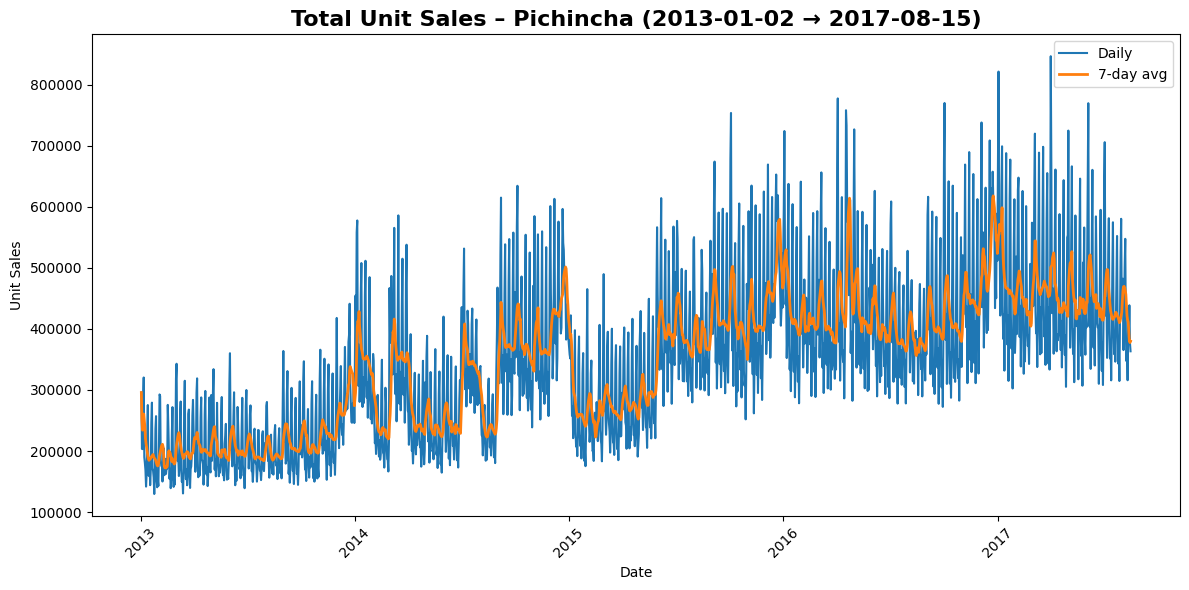

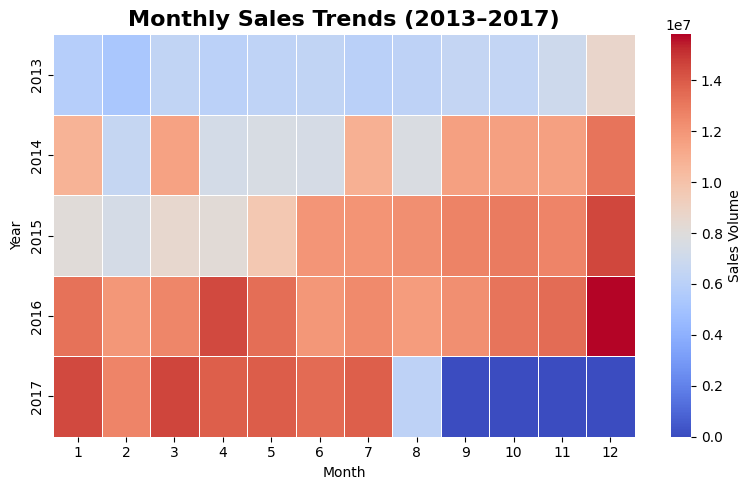

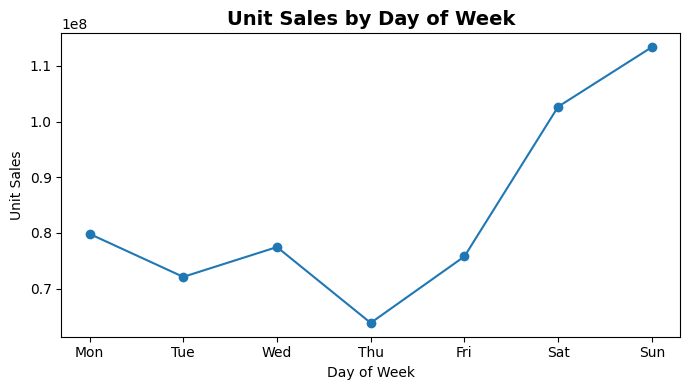

In [22]:
# a) Total Sales (alle Daten)
plt.figure(figsize=(12,6))
plt.plot(sales_by_date_all.index, sales_by_date_all.values, label='Daily')
plt.plot(sales_by_date_all.rolling(7, min_periods=1).mean(), label='7-day avg', linewidth=2)
plt.title(f"Total Unit Sales – Pichincha ({sales_by_date_all.index.min().date()} → {sales_by_date_all.index.max().date()})",
          fontsize=16, fontweight='bold')
plt.xlabel('Date'); plt.ylabel('Unit Sales'); plt.xticks(rotation=45); plt.legend()
plt.tight_layout(); plt.show()

# b) Year–Month Heatmap (alle Daten)
import seaborn as sns
sales_by_month_all = sales_by_month_all.reindex(columns=range(1,13))
plt.figure(figsize=(8,5))
sns.heatmap(sales_by_month_all.fillna(0), cmap='coolwarm', linewidths=0.5, linecolor='white',
            cbar_kws={'label':'Sales Volume'})
plt.title(f"Monthly Sales Trends ({int(sales_by_month_all.index.min())}–{int(sales_by_month_all.index.max())})",
          fontsize=16, fontweight='bold')
plt.xlabel('Month'); plt.ylabel('Year'); plt.tight_layout(); plt.show()

# c) Weekday Pattern (alle Daten)
plt.figure(figsize=(7,4))
plt.plot(sales_by_wd_all.index, sales_by_wd_all.values, marker='o')
plt.xticks([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Unit Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week'); plt.ylabel('Unit Sales')
plt.tight_layout(); plt.show()

## Block 11 — EDA Step 6: Holidays-Impact (robust, ohne Duplikate)

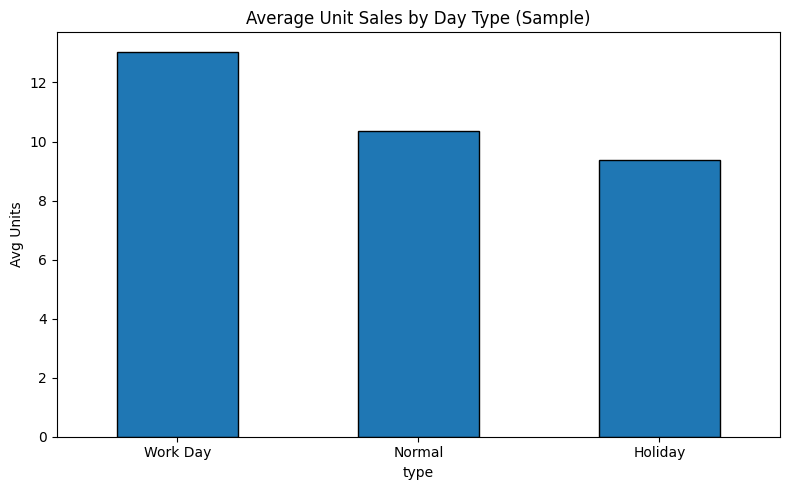

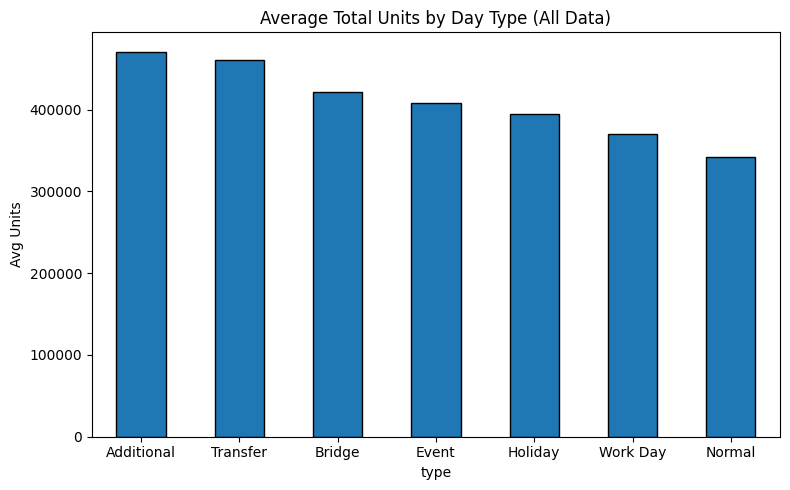

In [24]:
# Variante A: auf df_train (handliches Sample)
df_th = df_train.merge(df_day, on='date', how='left')

# robustes Füllen mit 'Normal'
if pd.api.types.is_categorical_dtype(df_th['type']):
    df_th['type'] = df_th['type'].cat.add_categories(['Normal']).fillna('Normal')
else:
    df_th['type'] = df_th['type'].fillna('Normal')

holiday_means = (df_th.groupby('type', observed=True)['unit_sales']
                 .mean().sort_values(ascending=False))
holiday_means.plot(kind='bar', edgecolor='black', figsize=(8,5))
plt.title('Average Unit Sales by Day Type (Sample)'); plt.ylabel('Avg Units'); plt.xticks(rotation=0)
plt.tight_layout(); plt.show()

# Variante B: auf allen Daten (daily totals)
daily_all = sales_by_date_all.rename_axis('date').reset_index()
daily_h   = daily_all.merge(df_day, on='date', how='left')

# robustes Füllen mit 'Normal'
if pd.api.types.is_categorical_dtype(daily_h['type']):
    daily_h['type'] = daily_h['type'].cat.add_categories(['Normal']).fillna('Normal')
else:
    daily_h['type'] = daily_h['type'].fillna('Normal')

means_all = daily_h.groupby('type')['unit_sales'].mean().sort_values(ascending=False)
means_all.plot(kind='bar', edgecolor='black', figsize=(8,5))
plt.title('Average Total Units by Day Type (All Data)'); plt.ylabel('Avg Units'); plt.xticks(rotation=0)
plt.tight_layout(); plt.show()


## Block 12 — EDA Step 7: Perishable Items

Items dataset preview:


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


Merged df_train + perishable flag:


,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,perishable
0,2013-01-10,1,96995,1.0,False,-0.526104,False,2013,1,10,3,1.0,False
1,2013-01-11,1,96995,1.0,False,-0.526104,False,2013,1,11,4,1.0,False
2,2013-01-14,1,96995,1.0,False,-0.526104,False,2013,1,14,0,1.0,False
3,2013-01-25,1,96995,1.0,False,-0.526104,False,2013,1,25,4,1.0,False
4,2013-01-28,1,96995,1.0,False,-0.526104,False,2013,1,28,0,1.0,False


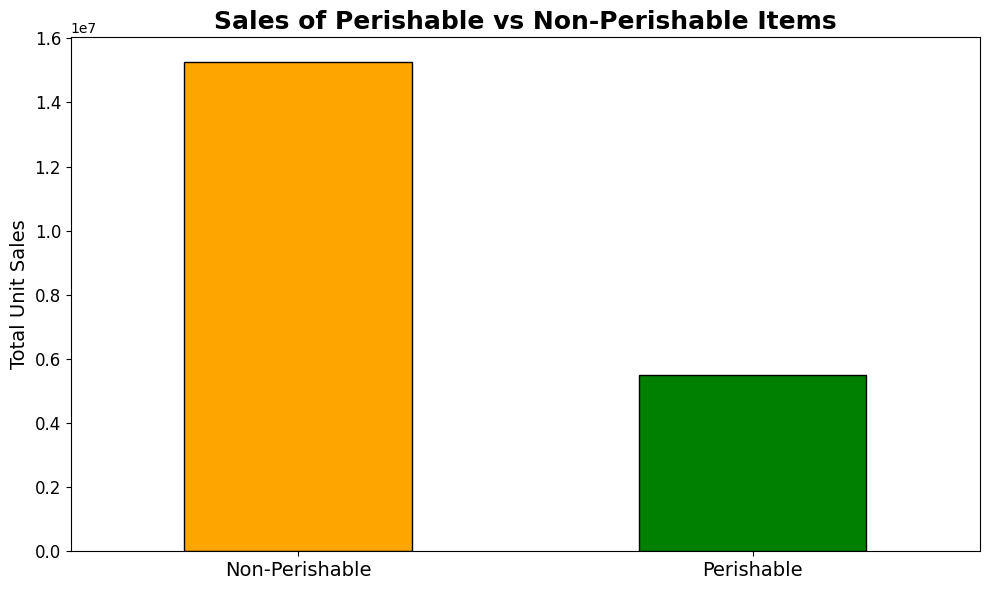

Total sales volume by category:
perishable
False    15265567.0
True      5495771.0
Name: unit_sales, dtype: float32


In [25]:
print("Items dataset preview:")
display(df_items.head())

df_train_items = pd.merge(df_train, df_items[['item_nbr','perishable']],
                          on='item_nbr', how='left')

df_train_items['perishable'] = df_train_items['perishable'].astype(bool)

print("Merged df_train + perishable flag:")
display(df_train_items.head())

perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plot
plt.figure(figsize=(10,6))
perishable_sales.plot(kind='bar',
                      color=['orange','green'],
                      edgecolor='black')

plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=18, fontweight='bold')
plt.ylabel('Total Unit Sales', fontsize=14)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=14,
    rotation=0
)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Ausgabe für Analyse
print("Total sales volume by category:")
print(perishable_sales)

## Block 13 — EDA Step 8: Oil Prices vs. Sales

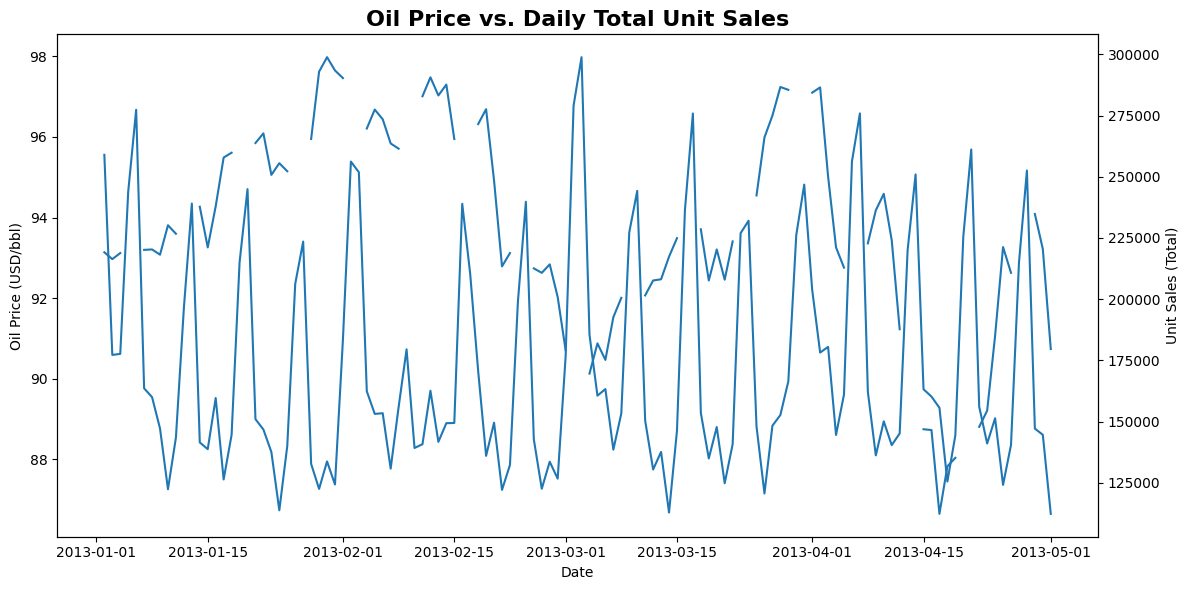

Zeitfenster: 2013-01-02 → 2013-05-01
Erste Sichtprüfung: Häufig keine klare tägliche Kopplung sichtbar; Oil zeigt Makro-Schwankungen, Sales steigen eher strukturell.



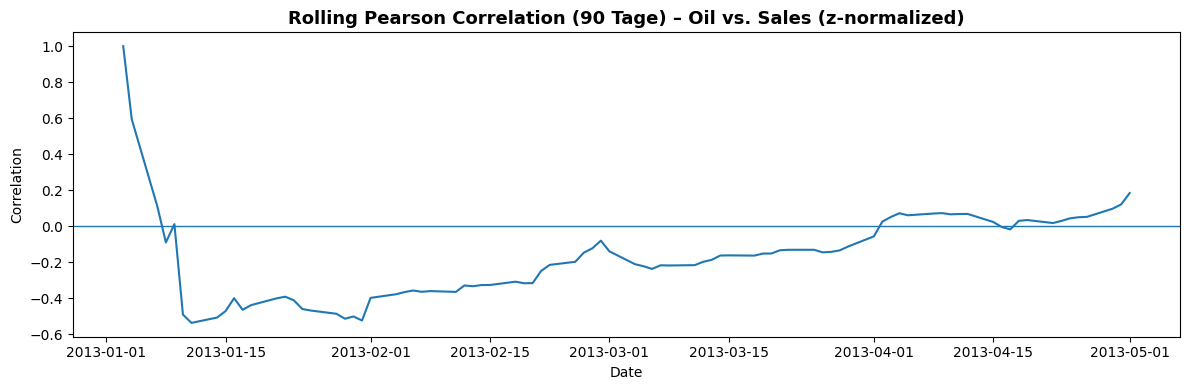

Year-by-Year Pearson r (Oil vs. Sales):


,pearson_r
year,
2013,0.008934


Hinweis: Zoom-Fenster enthält keine Daten; passe zoom_start/zoom_end an.


16783

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc

df_oil['date'] = pd.to_datetime(df_oil['date'], errors='coerce')
df_oil = df_oil.sort_values('date')

df_oil['dcoilwtico'] = pd.to_numeric(df_oil['dcoilwtico'], errors='coerce')
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate('linear').ffill().bfill()

# Daily Total Sales aus df_train
sales_by_date = (
    df_train
    .groupby('date', observed=True)['unit_sales']
    .sum()
    .sort_index()
    .rename('unit_sales')
    .reset_index()
)

# Mergen: sales (links) + oil (rechts) auf Datum
df_oil_sales = sales_by_date.merge(df_oil[['date','dcoilwtico']], on='date', how='left')

# Dual-Axis-Plot (Oil vs. Sales)
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df_oil_sales['date'], df_oil_sales['dcoilwtico'], label='Oil Price (WTI)', linewidth=1.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price (USD/bbl)', color='black')

ax2 = ax1.twinx()
ax2.plot(df_oil_sales['date'], df_oil_sales['unit_sales'], label='Total Unit Sales', linewidth=1.5)
ax2.set_ylabel('Unit Sales (Total)', color='black')

plt.title('Oil Price vs. Daily Total Unit Sales', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

# Kurze textliche Einordnung
start, end = df_oil_sales['date'].min().date(), df_oil_sales['date'].max().date()
print(f"Zeitfenster: {start} → {end}")
print("Erste Sichtprüfung: Häufig keine klare tägliche Kopplung sichtbar; Oil zeigt Makro-Schwankungen, Sales steigen eher strukturell.\n")


# (A) Rolling Korrelation (z.B. 90 Tage) — hilft, Episoden mit Kopplung zu sehen
try:
    tmp = df_oil_sales[['date','unit_sales','dcoilwtico']].dropna().set_index('date').sort_index()
    # z-Standardisierung
    z = lambda s: (s - s.mean()) / s.std(ddof=0)
    tmp_z = tmp.copy()
    tmp_z['unit_sales']  = z(tmp['unit_sales'])
    tmp_z['dcoilwtico']  = z(tmp['dcoilwtico'])
    roll_corr = tmp_z['unit_sales'].rolling('90D').corr(tmp_z['dcoilwtico'])

    plt.figure(figsize=(12,4))
    plt.plot(roll_corr.index, roll_corr.values)
    plt.axhline(0, linewidth=1)
    plt.title('Rolling Pearson Correlation (90 Tage) – Oil vs. Sales (z-normalized)', fontsize=13, fontweight='bold')
    plt.xlabel('Date'); plt.ylabel('Correlation')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Rolling correlation übersprungen:", e)

# (B) Year-by-Year Pearson r — zeigt „Spezialjahre“
try:
    df_oil_sales['year'] = df_oil_sales['date'].dt.year
    corr_by_year = (
        df_oil_sales.dropna(subset=['unit_sales','dcoilwtico'])
        .groupby('year')[['unit_sales','dcoilwtico']]
        .corr().unstack().iloc[:, df_oil_sales.columns.get_indexer(['unit_sales','dcoilwtico']).tolist()[1] - 1]  # sichere Auswahl
    )
    # Einfacher: direkt berechnen ohne fancy indexing
    corr_by_year = (
        df_oil_sales.dropna(subset=['unit_sales','dcoilwtico'])
        .groupby('year')
        .apply(lambda g: g['unit_sales'].corr(g['dcoilwtico']))
        .rename('pearson_r')
    )
    print("Year-by-Year Pearson r (Oil vs. Sales):")
    display(corr_by_year.to_frame())
except Exception as e:
    print("Year-by-year correlation übersprungen:", e)

# (C) Zoom-Fenster (einfach Start/Ende ändern)
# Beispiel: Zoom auf ein halbes Jahr
zoom_start = pd.to_datetime('2014-01-01')
zoom_end   = pd.to_datetime('2014-06-30')
zoom = df_oil_sales[(df_oil_sales['date'] >= zoom_start) & (df_oil_sales['date'] <= zoom_end)]

if not zoom.empty:
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(zoom['date'], zoom['dcoilwtico'], label='Oil', linewidth=1.5)
    ax1.set_ylabel('Oil Price (USD/bbl)')
    ax2 = ax1.twinx()
    ax2.plot(zoom['date'], zoom['unit_sales'], label='Sales', linewidth=1.5)
    ax2.set_ylabel('Unit Sales')
    plt.title(f'Oil vs. Sales — Zoom {zoom_start.date()} → {zoom_end.date()}', fontsize=13, fontweight='bold')
    fig.tight_layout(); plt.show()
else:
    print("Hinweis: Zoom-Fenster enthält keine Daten; passe zoom_start/zoom_end an.")

# Aufräumen
del sales_by_date, df_oil_sales, zoom
gc.collect()

## Block 14 — EDA Summary and Key Takeaways

In [28]:
from IPython.display import Markdown

summary_text = """
# 📊 EDA Summary and Key Takeaways

## 🔄 Session Recap – From Raw CSV to Business Insights

| Step | What we did | Why it matters |
|------|-------------|----------------|
| **1. Loaded data** | Pulled Favorita sales (`train.csv`) + metadata (stores, items, holidays, oil, transactions). | Brought all raw info into one workspace. |
| **2. Basic cleaning** | Filled `onpromotion` NaNs with False. Clipped negative `unit_sales` to 0. Checked for extreme z-score outliers. | Removed obvious issues and prevented confusion from returns. |
| **3. Filled the calendar** | Re-indexed each `(store, item)` to full daily date range; inserted 0-sales rows. | Ensured consistent daily time-series → critical for lag features & no leakage. |
| **4. Feature engineering** | Added `year, month, day, day_of_week` + 7-day rolling mean (`unit_sales_7d_avg`). | Created seasonal & momentum signals for models. |
| **5. Exploratory plots** | a) Line plot: upward trend, yearly dips. <br> b) Heatmap: Dec peaks, Q1 lulls, strange Aug 2017 drop. | Visualized trend & seasonality, flagged anomalies. |
| **6. Holiday effect** | Merged holiday calendar → bar chart of avg. sales by day-type. | Showed which days lift/suppress demand → informs promos & staffing. |
| **7. Perishable focus** | Merged `df_items`, split perishable vs non-perishable, plotted totals. | Found perishables ≈ 35% volume → waste-sensitive, needs tighter forecasts. |
| **8. Oil prices** | Aggregated daily totals, merged with WTI oil prices, dual-axis plot. | Saw no strong correlation → oil is weak as predictive feature. |
| **9. Saved progress** | Pickled the cleaned `df_train` with features. | Allows fast reload without recomputation. |

---

## 📌 Key Takeaways
- Handle missing data and outliers carefully in time-series datasets.
- Always build a complete daily calendar (no gaps, no leaks).
- Visualization is your first diagnostic tool for trend, seasonality & anomalies.
- Feature engineering (date parts, rolling means) is crucial for forecasting.
- External factors (holidays, oil, perishables) provide context, but not all are equally predictive.

✅ You now have a **gap-free, feature-rich dataset + visuals** → ready for **time-series modelling** in the next sprint.

---

### 🔜 Next Steps (Advanced)
- Time-series characteristics: **Autocorrelation** & **Stationarity**
- Build forecasting models: baseline → advanced
"""

display(Markdown(summary_text))



# 📊 EDA Summary and Key Takeaways

## 🔄 Session Recap – From Raw CSV to Business Insights

| Step | What we did | Why it matters |
|------|-------------|----------------|
| **1. Loaded data** | Pulled Favorita sales (`train.csv`) + metadata (stores, items, holidays, oil, transactions). | Brought all raw info into one workspace. |
| **2. Basic cleaning** | Filled `onpromotion` NaNs with False. Clipped negative `unit_sales` to 0. Checked for extreme z-score outliers. | Removed obvious issues and prevented confusion from returns. |
| **3. Filled the calendar** | Re-indexed each `(store, item)` to full daily date range; inserted 0-sales rows. | Ensured consistent daily time-series → critical for lag features & no leakage. |
| **4. Feature engineering** | Added `year, month, day, day_of_week` + 7-day rolling mean (`unit_sales_7d_avg`). | Created seasonal & momentum signals for models. |
| **5. Exploratory plots** | a) Line plot: upward trend, yearly dips. <br> b) Heatmap: Dec peaks, Q1 lulls, strange Aug 2017 drop. | Visualized trend & seasonality, flagged anomalies. |
| **6. Holiday effect** | Merged holiday calendar → bar chart of avg. sales by day-type. | Showed which days lift/suppress demand → informs promos & staffing. |
| **7. Perishable focus** | Merged `df_items`, split perishable vs non-perishable, plotted totals. | Found perishables ≈ 35% volume → waste-sensitive, needs tighter forecasts. |
| **8. Oil prices** | Aggregated daily totals, merged with WTI oil prices, dual-axis plot. | Saw no strong correlation → oil is weak as predictive feature. |
| **9. Saved progress** | Pickled the cleaned `df_train` with features. | Allows fast reload without recomputation. |

---

## 📌 Key Takeaways
- Handle missing data and outliers carefully in time-series datasets.  
- Always build a complete daily calendar (no gaps, no leaks).  
- Visualization is your first diagnostic tool for trend, seasonality & anomalies.  
- Feature engineering (date parts, rolling means) is crucial for forecasting.  
- External factors (holidays, oil, perishables) provide context, but not all are equally predictive.  

✅ You now have a **gap-free, feature-rich dataset + visuals** → ready for **time-series modelling** in the next sprint.

---

### 🔜 Next Steps (Advanced)
- Time-series characteristics: **Autocorrelation** & **Stationarity**  
- Build forecasting models: baseline → advanced  


## Block 15 — Cleaned-Frame speichern (für späteres Arbeiten)



In [30]:
from google.colab import drive
import os

drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/time_series_course"
os.makedirs(save_dir, exist_ok=True)

clean_path = os.path.join(save_dir, "df_train_clean.pkl")
df_train.to_pickle(clean_path)
print("✅ DataFrame gespeichert unter:", clean_path)

df_train_reload = pd.read_pickle(clean_path)
print("📦 Reload erfolgreich, Shape:", df_train_reload.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ DataFrame gespeichert unter: /content/drive/MyDrive/time_series_course/df_train_clean.pkl
📦 Reload erfolgreich, Shape: (2000000, 12)


## 📦 Block 16 — Advanced EDA: Autocorrelation

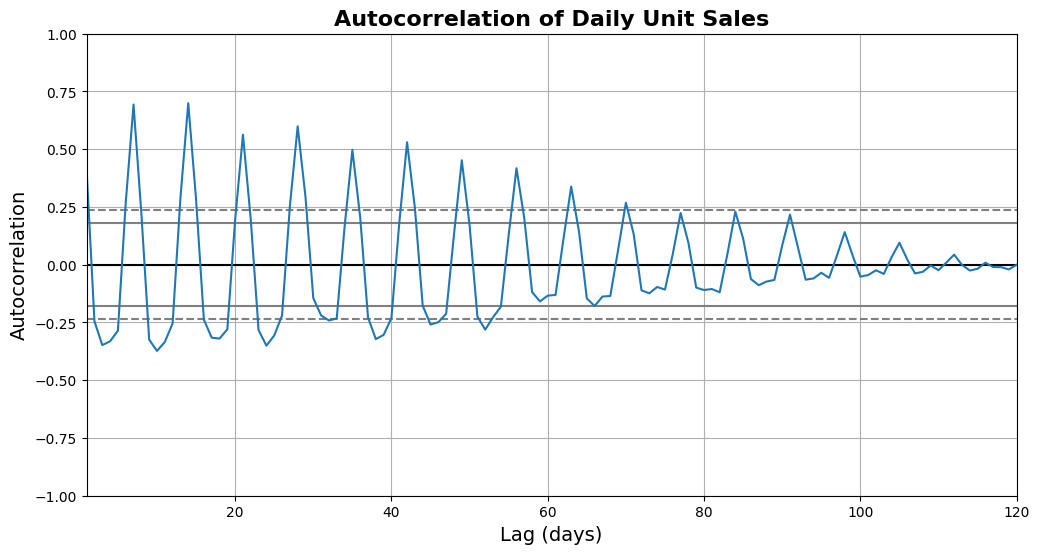

In [31]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

sales_by_date = df_train.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(12,6))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16, fontweight='bold')
plt.xlabel('Lag (days)', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.show()

## Block 17 — Advanced EDA: Stationarity (Visual + ADF + STL)

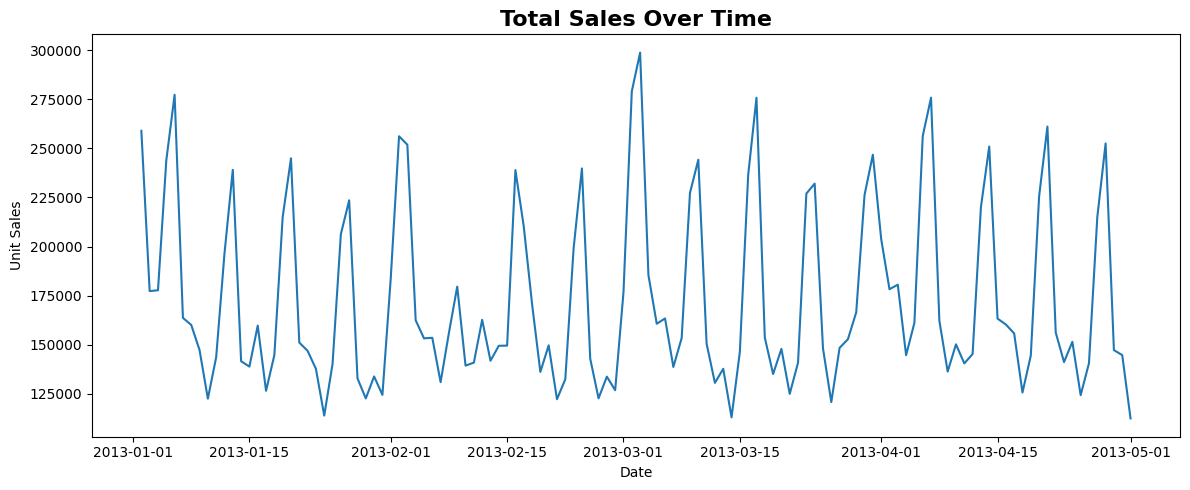

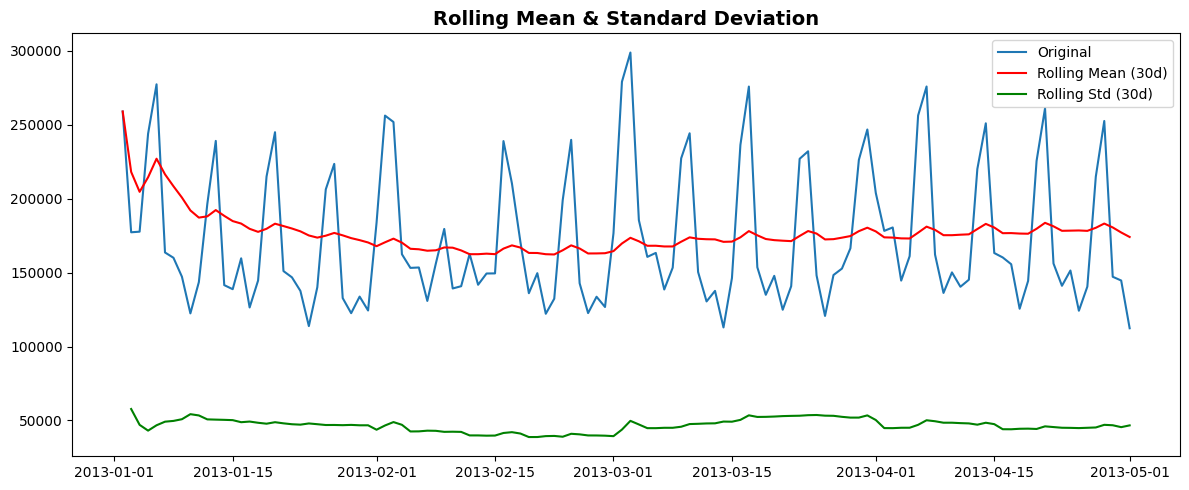

ADF Statistic: -1.9322308044712018
p-value: 0.31705388978151683
Critical Value (1%): -3.494
Critical Value (5%): -2.889
Critical Value (10%): -2.582

Interpretation: p < 0.05 → stationär; p ≥ 0.05 → wahrscheinlich nicht stationär.


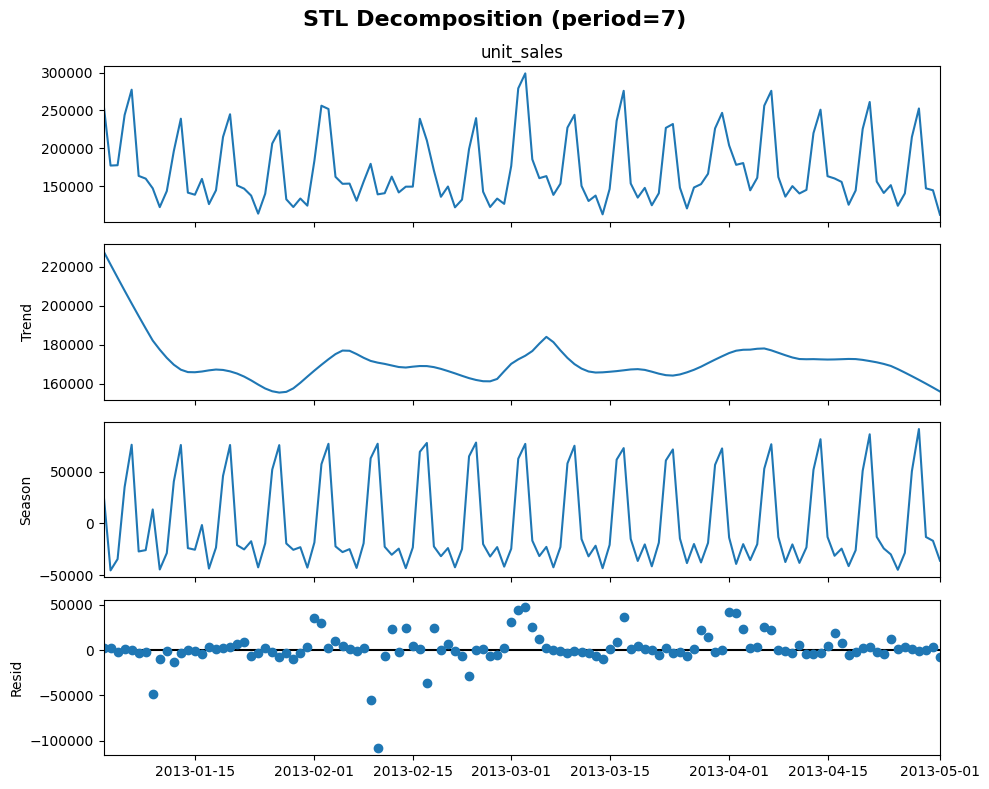

Strength of Trend:       0.32  (≈1 → sehr stark)
Strength of Seasonality: 0.84  (≈1 → sehr stark)

FAZIT:
- Sichtbar: Trend + deutliche (wöchentliche) Saisonmuster → Nicht-Stationarität in der Mittelwertstruktur.
- ADF-Test bestätigt i.d.R. Nicht-Stationarität (p-Wert häufig > 0.05).
- Für ARIMA/klassische Modelle: Differenzieren (z.B. 1. Differenz, ggf. saisonale Differenz) und/oder Komponenten abtrennen (STL).
- Für ML/Deep Learning: Lag-Features & saisonale Features nutzen; Log-Transform bei stark rechtsschiefer Verteilung erwägen.


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

try:
    sales_by_date
except NameError:
    sales_by_date = (
        df_train.groupby('date', observed=True)['unit_sales']
        .sum()
        .sort_index()
    )

# 1) Visual check: Rohserie
plt.figure(figsize=(12,5))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Sales Over Time', fontsize=16, fontweight='bold')
plt.ylabel('Unit Sales'); plt.xlabel('Date')
plt.tight_layout(); plt.show()

# 2) Visual check: Rolling Mean & Std
rolling_mean = sales_by_date.rolling(window=30, min_periods=1).mean()
rolling_std  = sales_by_date.rolling(window=30, min_periods=1).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean (30d)', color='red')
plt.plot(rolling_std,  label='Rolling Std (30d)',  color='green')
plt.title('Rolling Mean & Standard Deviation', fontsize=14, fontweight='bold')
plt.legend(); plt.tight_layout(); plt.show()

# 3) ADF-Test (Augmented Dickey-Fuller)
adf_series = sales_by_date.dropna().astype(float).values
adf_result = adfuller(adf_series, autolag='AIC')
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for k, v in adf_result[4].items():
    print(f"Critical Value ({k}): {v:.3f}")
print("\nInterpretation: p < 0.05 → stationär; p ≥ 0.05 → wahrscheinlich nicht stationär.")

# 4) STL-Decomposition (weekly seasonality -> period=7)
stl = STL(sales_by_date, period=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 8)
plt.suptitle("STL Decomposition (period=7)", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# 5) Stärke von Trend & Seasonality (Hyndman-Definition)
trend_strength = 1 - (np.var(res.resid, ddof=0) / np.var(res.trend + res.resid, ddof=0))
seasonal_strength = 1 - (np.var(res.resid, ddof=0) / np.var(res.seasonal + res.resid, ddof=0))

print(f"Strength of Trend:       {trend_strength:.2f}  (≈1 → sehr stark)")
print(f"Strength of Seasonality: {seasonal_strength:.2f}  (≈1 → sehr stark)")

# 6) Kurzfazit als Prints
print("\nFAZIT:")
print("- Sichtbar: Trend + deutliche (wöchentliche) Saisonmuster → Nicht-Stationarität in der Mittelwertstruktur.")
print("- ADF-Test bestätigt i.d.R. Nicht-Stationarität (p-Wert häufig > 0.05).")
print("- Für ARIMA/klassische Modelle: Differenzieren (z.B. 1. Differenz, ggf. saisonale Differenz) und/oder Komponenten abtrennen (STL).")
print("- Für ML/Deep Learning: Lag-Features & saisonale Features nutzen; Log-Transform bei stark rechtsschiefer Verteilung erwägen.")

## Block 18 — Speichern für die nächste Woche

In [34]:
from google.colab import drive
drive.mount('/content/drive')

import os
save_dir = "/content/drive/MyDrive/time_series_course"
os.makedirs(save_dir, exist_ok=True)

pickle_path = os.path.join(save_dir, "df_train_advanced.pkl")
df_train.to_pickle(pickle_path)
print("Pickle gespeichert unter:", pickle_path)

csv_path = os.path.join(save_dir, "df_train_advanced.csv")
df_train.to_csv(csv_path, index=False)
print("CSV gespeichert unter:", csv_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pickle gespeichert unter: /content/drive/MyDrive/time_series_course/df_train_advanced.pkl
CSV gespeichert unter: /content/drive/MyDrive/time_series_course/df_train_advanced.csv
